**Burgers equation**

Retyped by Theodoret Putra Agatho on 4 Aug. 2023

Source: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html

**ReadMe!**
Before running this notebook in google colab, it's required to upload "Burgers.npz" file in google colab files section.

In [1]:
pip install deepxde

**Problem setup**

We will solve a Burger equation:

\begin{align}
        \frac{\delta y}{\delta t} + u \frac{\delta u}{\delta x} = v \frac{\delta ^2 u}{\delta x^2}, x \in [-1,1], t \in [0,1]
    \end{align}

with the Dirichlet boundary conditions and initial conditions

\begin{align}
        u(-1,t) = u(1,t) = 0, u(x, 0) = -sin(\pi x).
    \end{align}

The reference solution is [here](https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Burgers.npz)

**Implementation**

This description goes through the implementation of a solver for the above described Burgers equation step-by-step.

First, the DeepXDE and TensorFlow (`tf`) modules are imported:

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



We begin by defining a computational geometry and time domain. We can use a built-in class `Interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the Burgers equation:

In [4]:
def pde(x, y):
  dy_x = dde.grad.jacobian(y, x, i=0, j=0)
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

The first argument to `pde` is 2-dimensional vector where the first component (`x[:,0]`) is $x$-coordinate and the the second componenet (`x[:,1]`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $u(x,t)$, but here we use `y` as the name of the variable.

Next, we consider the boundary/initial condition. `on_boundary` is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. We include the `geomtime` space, time geomtery created above and `on_boundary` as the BCs in the `DirichletBC` function of DeepXDE. We also define `IC` which is the initial conditon for the burgers equation and we use the computational domain, initial function, and `on_initial` to specify the IC.

In [5]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

Now, we have specified the geometry, PDE residual, and boundary/initial condition. We thend efine the `TimePDE` problem as

In [6]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=2540, num_boundary=80, num_initial=160)

The number 2540 is the number of training residual points sampled inside the domain, and the number 80 is the number of training points sampled on the boundary. We also include 160 initial residual points for the initial conditions.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:

In [7]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [8]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.177482 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.437592 s



We then train the model for 15000 iterations:

In [9]:
losshistory, train_state = model.train(iterations=15000)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.61e-02, 2.64e-02, 5.18e-01]    [8.61e-02, 2.64e-02, 5.18e-01]    []  
1000      [4.06e-02, 1.16e-03, 6.06e-02]    [4.06e-02, 1.16e-03, 6.06e-02]    []  
2000      [3.03e-02, 3.06e-05, 4.50e-02]    [3.03e-02, 3.06e-05, 4.50e-02]    []  
3000      [8.05e-03, 4.23e-05, 7.05e-03]    [8.05e-03, 4.23e-05, 7.05e-03]    []  
4000      [3.13e-03, 7.42e-06, 2.35e-03]    [3.13e-03, 7.42e-06, 2.35e-03]    []  
5000      [2.22e-03, 3.86e-06, 1.82e-03]    [2.22e-03, 3.86e-06, 1.82e-03]    []  
6000      [1.80e-03, 2.44e-06, 1.58e-03]    [1.80e-03, 2.44e-06, 1.58e-03]    []  
7000      [1.54e-03, 2.17e-06, 1.44e-03]    [1.54e-03, 2.17e-06, 1.44e-03]    []  
8000      [1.43e-03, 1.85e-06, 1.32e-03]    [1.43e-03, 1.85e-06, 1.32e-03]    []  
9000      [1.18e-03, 1.51e-06, 1.22e-03]    [1.18e-03, 1.51e-06, 1.22e-03]    []  
10000     [1.04e-03, 1.14e-06, 1.11e-03]    [1.04e-03, 1.14e-

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [10]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.330501 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [6.28e-04, 1.27e-06, 6.41e-04]    [6.28e-04, 1.27e-06, 6.41e-04]    []  
16000     [1.35e-04, 7.44e-07, 6.35e-05]    [1.35e-04, 7.44e-07, 6.35e-05]        
17000     [5.83e-05, 1.74e-07, 2.59e-05]    [5.83e-05, 1.74e-07, 2.59e-05]        
18000     [3.52e-05, 1.92e-07, 1.46e-05]    [3.52e-05, 1.92e-07, 1.46e-05]        
19000     [2.24e-05, 6.76e-08, 5.57e-06]    [2.24e-05, 6.76e-08, 5.57e-06]        
20000     [1.40e-05, 3.68e-08, 2.26e-06]    [1.40e-05, 3.68e-08, 2.26e-06]        
21000     [1.10e-05, 3.13e-08, 6.94e-07]    [1.10e-05, 3.13e-08, 6.94e-07]        
21752     [8.00e-06, 4.11e-08, 7.33e-07]    [8.00e-06, 4.11e-08, 7.33e-07]    []  

Best model at step 21752:
  train loss: 8.77e-06
  test loss: 8.77e-06
  test metric: []

'train' took 100.755138 s



**Additional Visualisation**

Additional code to give visualisation of the results. Taken parts are from **Complete code** section.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


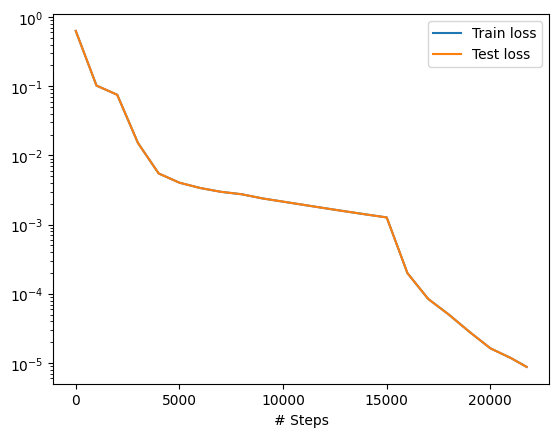

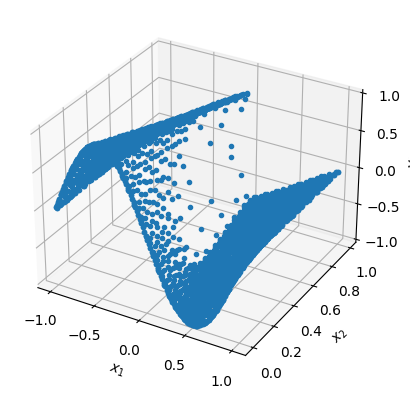

In [11]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [12]:
def gen_testdata():
  data = np.load("../content/Burgers.npz")
  t, x, exact = data["t"], data["x"], data["usol"].T
  xx, tt = np.meshgrid(x, t)
  X = np.vstack((np.ravel(xx), np.ravel(tt))).T
  y = exact.flatten()[:, None]
  return X, y

In [13]:
X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.004034186
L2 relative error 0.009456259071407144
